In [40]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))
house_prices <- source('main.R', local = TRUE)$value

combined_dataset_step1 <-
    # load data
    house_prices$helpers$load_data() %>%
    # remove outliers
    (house_prices$outliers$remove_outliers) %>%
    # fix NA values
    (house_prices$missing$fix_all) %>%
    # transform Y-variable
    mutate(
        price_log = log(SalePrice)
    ) %>%
    # remove redundant variables
    select(-SalePrice, -Id) %>%
    select(order(colnames(.)))

################################
# transform numeric predictors #
################################

c(combined_dataset_step2, trans_config) %<-%
    house_prices$trans$numeric$functional_transform(
        data = combined_dataset_step1,
        trans = tribble(
            ~tran_name,  ~tran_fn,
            'log',       function(x) log(x+1),
            'sqrt',      function(x) sqrt(x),
            'inv3',      function(x) x**(1/3),
            'inv4',      function(x) x**(1/4)
        ),
        target_var = price_log,        
        threshold = 30
    )    
combined_dataset_step2 <- combined_dataset_step2 %>% select(order(colnames(.)))
                
trans_config

house_prices$helpers$utils$frames_diff(
    combined_dataset_step1, 
    combined_dataset_step2
) %>% head

####################################                
# transform categorical predictors #
####################################
combined_dataset_step3 <- 
    house_prices$trans$categ$rating_transform(
        data = combined_dataset_step2, 
        target_var = price_log
    ) %>% 
    select(order(colnames(.)))

house_prices$helpers$utils$frames_diff(
    combined_dataset_step2, 
    combined_dataset_step3
) %>% head

var,tran_name,progress_score,tran_fn
GrLivArea,log,91.15794,"function (x) , log(x + 1)"
X1stFlrSF,log,90.77166,"function (x) , log(x + 1)"
BsmtUnfSF,sqrt,79.97603,"function (x) , sqrt(x)"
LotArea,inv4,78.86403,"function (x) , x^(1/4)"
TotRmsAbvGrd,log,30.68502,"function (x) , log(x + 1)"


BsmtUnfSF.1,BsmtUnfSF.2,GrLivArea.1,GrLivArea.2,LotArea.1,LotArea.2,TotRmsAbvGrd.1,TotRmsAbvGrd.2,X1stFlrSF.1,X1stFlrSF.2
150,12.24745,1710,7.444833,8450,9.587694,8,2.197225,856,6.753438
284,16.85230,1262,7.141245,9600,9.898464,6,1.945910,1262,7.141245
434,20.83267,1786,7.488294,11250,10.298836,6,1.945910,920,6.825460
540,23.23790,1717,7.448916,9550,9.885550,7,2.079442,961,6.869014
490,22.13594,2198,7.695758,14260,10.927728,9,2.302585,1145,7.044033
64,8.00000,1362,7.217443,14115,10.899842,5,1.791759,796,6.680855


Alley.1,Alley.2,BldgType.1,BldgType.2,BsmtCond.1,BsmtCond.2,BsmtExposure.1,BsmtExposure.2,BsmtFinType1.1,BsmtFinType1.2,⋯,RoofStyle.1,RoofStyle.2,SaleCondition.1,SaleCondition.2,SaleType.1,SaleType.2,Street.1,Street.2,Utilities.1,Utilities.2
_none_,2.531822,1Fam,2.564039,TA,2.540871,No,2.320042,GLQ,3.262019,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,TA,2.540871,Gd,3.295455,ALQ,2.231818,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,TA,2.540871,Mn,2.675439,GLQ,3.262019,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,Gd,3.046154,No,2.320042,ALQ,2.231818,⋯,Gable,2.418054,Abnorml,1.920792,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,TA,2.540871,Av,2.900452,GLQ,3.262019,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,TA,2.540871,No,2.320042,GLQ,3.262019,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911


In [12]:
training_dataset <- 
    combined_dataset_step3 %>% 
    filter(dataSource == 'train') %>% 
    select(-dataSource)

mod <- lm(price_log ~ GrLivArea + OverallQual, data=training_dataset)

mod %>% glance
mod %>% tidy

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.7641906,0.7638664,0.194236,2357.618,0,3,321.8864,-635.7728,-614.6335,54.89371,1455


term,estimate,std.error,statistic,p.value
(Intercept),7.6588878,0.126036731,60.76711,0.000000e+00
GrLivArea,0.4565688,0.019430309,23.49777,9.051174e-104
OverallQual,0.1718658,0.004660648,36.87594,9.636469e-211


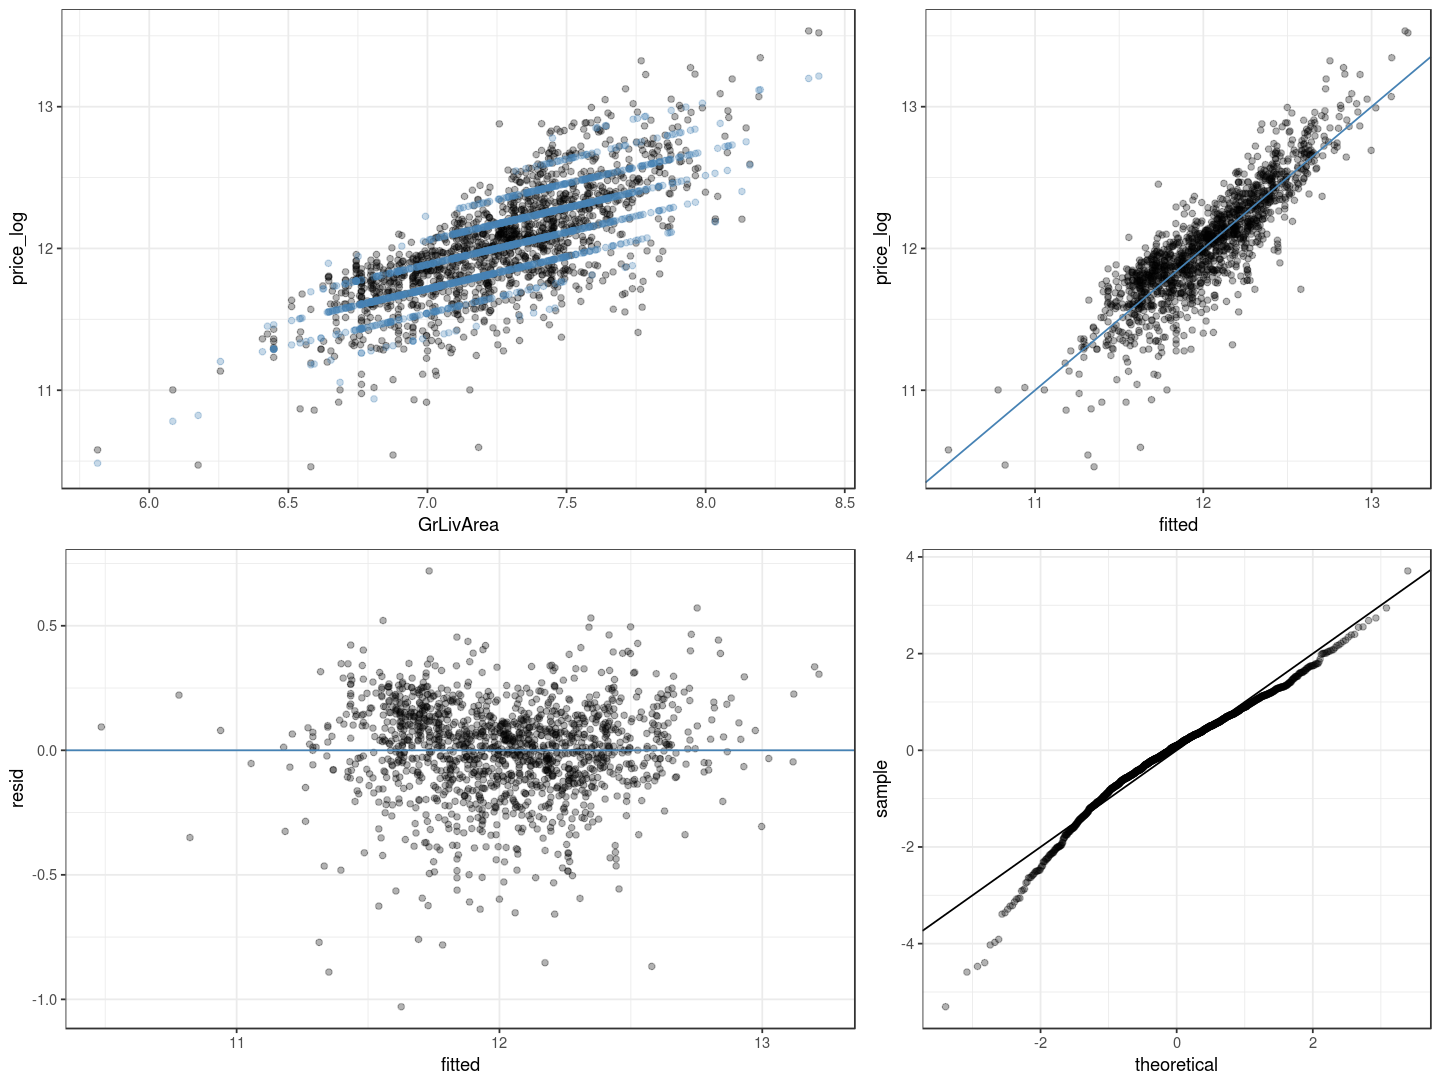

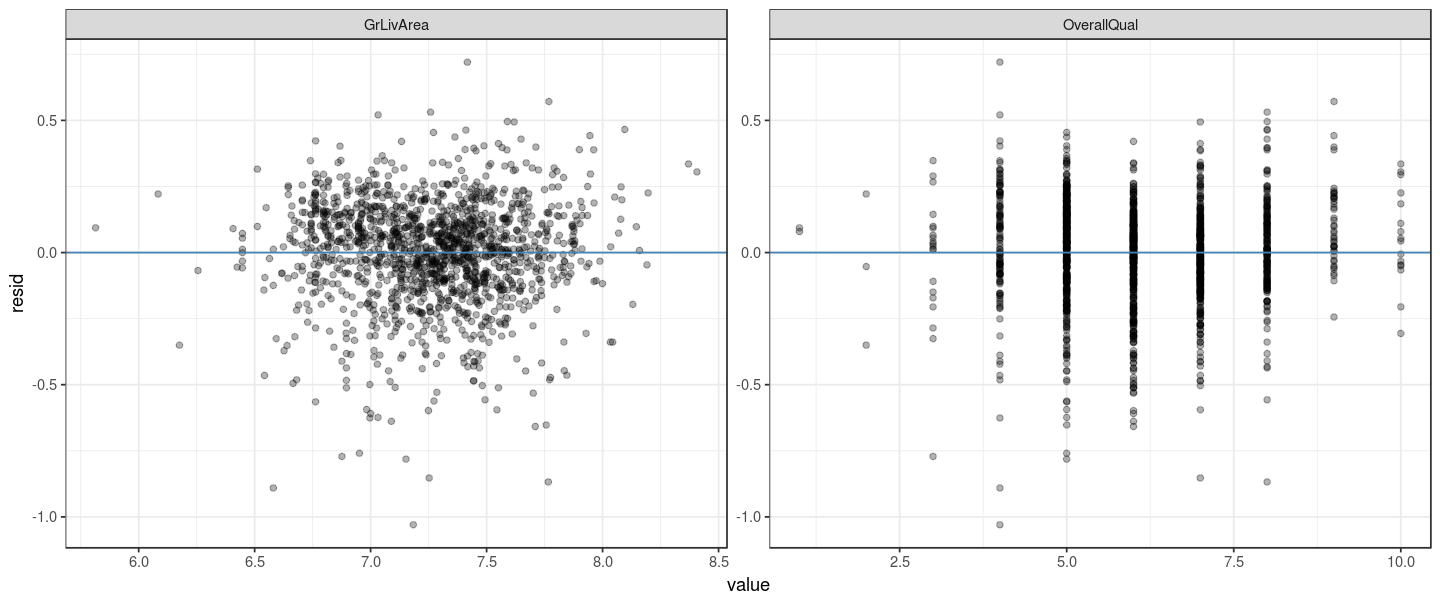

In [38]:
house_prices <- source('main.R', local = TRUE)$value

options(repr.plot.width = 12, repr.plot.height = 9)
house_prices$plot$lm_fit_diagnostic(mod, "GrLivArea", "price_log")

options(repr.plot.width = 12, repr.plot.height = 5)
house_prices$plot$lm_resid_vs_predictors(mod, 'price_log', ncol=2, nrow=1)

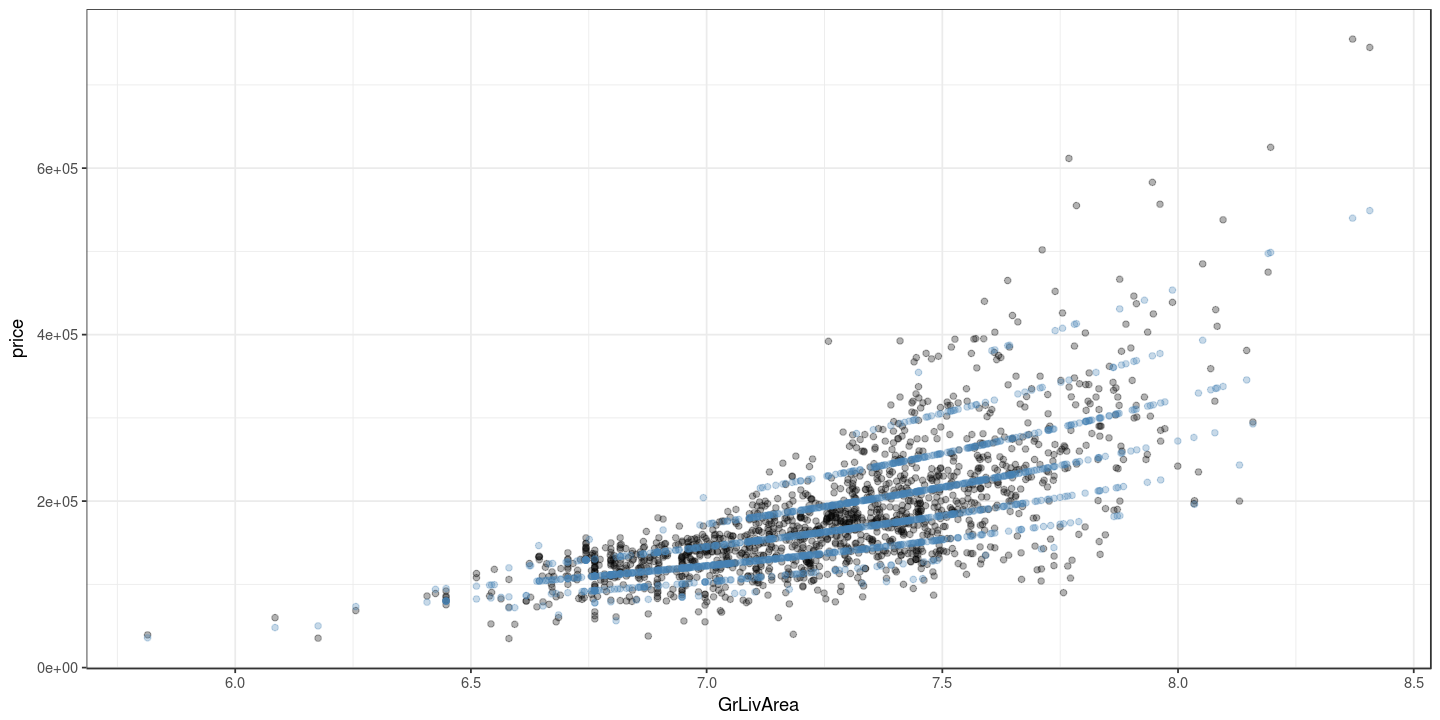

In [39]:
options(repr.plot.width = 12, repr.plot.height = 6)

mod %>%
augment %>%
mutate(
    price = exp(price_log),
    fitted_price = exp(.fitted)
) %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=price), alpha=0.3) +
geom_point(aes(x=GrLivArea, y=fitted_price), alpha=0.3, color='steelblue') +
theme_bw()

In [61]:
report <- house_prices$model_selection$lm$greedy_r2_gain_adj(
    data = training_dataset, 
    target_var = price_log, 
    r2_gain_discard_level = 0.4,
    r2_discard_level = 0.02, 
    a_max = 0, a_avg = 0
)

report %>% group_by(step) %>% filter(row_number() == 1)

predictor,formula,r2,step,base_r2,r2_gain,cor_abs_max,cor_abs_avg,r2_gain_adj
OverallQual,price_log ~ OverallQual,0.6747053,1,NA,NA,NA,NA,NA
GrLivArea,price_log ~ OverallQual + GrLivArea,0.7641906,2,0.6747053,13.2628602,0.6088750,0.6088750,13.2628602
Neighborhood,price_log ~ OverallQual + GrLivArea + Neighborhood,0.8132790,3,0.7641906,6.4235833,0.6790092,0.5732441,6.4235833
BsmtFinSF1,price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1,0.8493875,4,0.8132790,4.4398744,0.2426179,0.1983661,4.4398744
GarageArea,price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea,0.8611900,5,0.8493875,1.3895276,0.5572300,0.4547195,1.3895276
CentralAir,price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir,0.8702618,6,0.8611900,1.0533979,0.2725223,0.2138656,1.0533979
LotArea,price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir + LotArea,0.8776064,7,0.8702618,0.8439511,0.3697551,0.2320913,0.8439511
YearRemodAdd,price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir + LotArea + YearRemodAdd,0.8859860,8,0.8776064,0.9548328,0.5498273,0.3163918,0.9548328
TotalBsmtSF,price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir + LotArea + YearRemodAdd + TotalBsmtSF,0.8914477,9,0.8859860,0.6164546,0.5385945,0.4008991,0.6164546
SaleCondition,price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir + LotArea + YearRemodAdd + TotalBsmtSF + SaleCondition,0.8955288,10,0.8914477,0.4577993,0.3408061,0.2069990,0.4577993


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.8955288,0.8948068,0.1296417,1240.37,0,11,915.3743,-1806.749,-1743.331,24.31969,1447


term,estimate,std.error,statistic,p.value
(Intercept),3.607593e+00,4.204620e-01,8.580069,2.404098e-17
OverallQual,8.217099e-02,4.244515e-03,19.359337,1.964879e-74
GrLivArea,3.700026e-01,1.408728e-02,26.265013,1.185356e-124
Neighborhood,7.392552e-02,6.087868e-03,12.143088,2.212084e-32
BsmtFinSF1,1.247658e-04,9.091481e-06,13.723375,2.207869e-40
GarageArea,1.574147e-04,2.109479e-05,7.462255,1.461149e-13
CentralAir,1.103831e-01,1.166927e-02,9.459301,1.206174e-20
LotArea,3.098823e-02,3.066630e-03,10.104977,3.036291e-23
YearRemodAdd,2.036066e-03,2.134084e-04,9.540702,5.779085e-21
TotalBsmtSF,8.960838e-05,1.124558e-05,7.968318,3.233009e-15


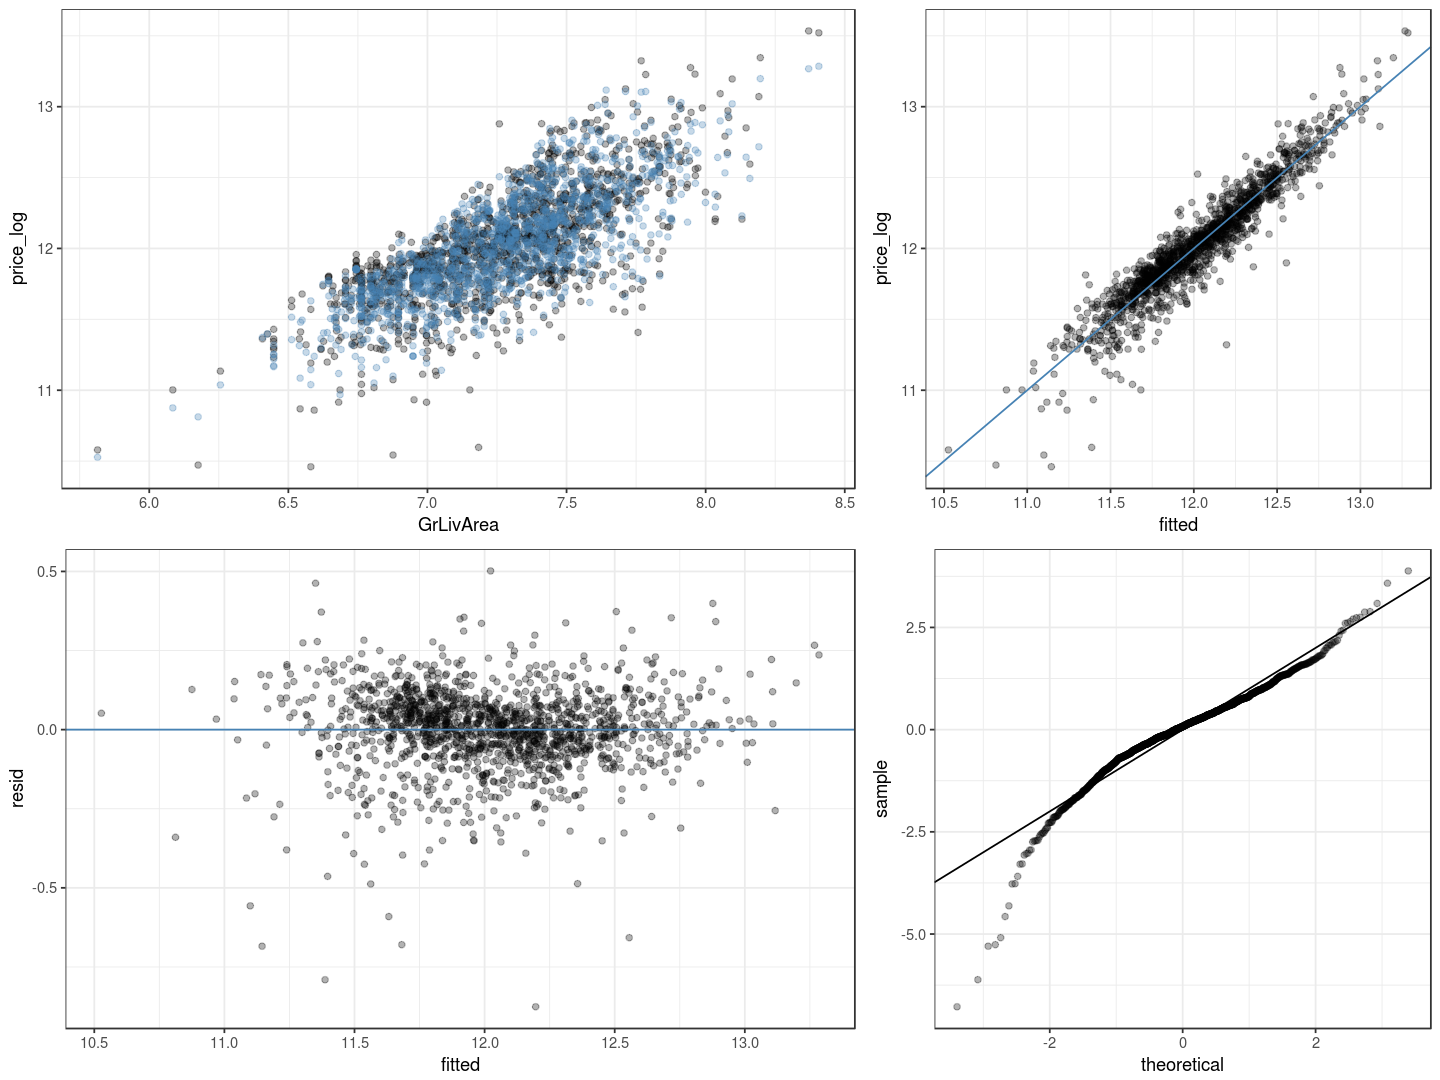

In [60]:
f <- report %>% filter(step == max(step)) %>% filter(r2_gain_adj == max(r2_gain_adj)) %>% `[[`('formula')

mod <- lm(as.formula(f), data=training_dataset)

mod %>% glance
mod %>% tidy

options(repr.plot.width = 12, repr.plot.height = 9)
house_prices$plot$lm_fit_diagnostic(mod, "GrLivArea", "price_log")

In [46]:
report <- house_prices$model_selection$lm$greedy_r2_gain_adj(
    data = training_dataset, 
    target_var = price_log, 
    r2_gain_discard_level = 0.4,
    r2_discard_level = 0.02, 
    a_max = 1, a_avg = 1
)

report %>% group_by(step) %>% filter(row_number() == 1)

predictor,formula,r2,step,base_r2,r2_gain,cor_abs_max,cor_abs_avg,r2_gain_adj
OverallQual,price_log ~ OverallQual,0.6747053,1,NA,NA,NA,NA,NA
LotArea,price_log ~ OverallQual + LotArea,0.7462617,2,0.6747053,10.6055769,0.1645073,0.1645073,7.9800309
GrLivArea,price_log ~ OverallQual + LotArea + GrLivArea,0.7948710,3,0.7462617,6.5136974,0.6088750,0.4893150,3.1044364
BsmtFinSF1,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1,0.8293951,4,0.7948710,4.3433605,0.2224668,0.1890097,3.0771752
YearBuilt,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt,0.8608866,5,0.8293951,3.7969295,0.5713681,0.2684758,2.0637237
SaleCondition,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition,0.8688046,6,0.8608866,0.9197446,0.3479601,0.1797324,0.6020482
CentralAir,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition + CentralAir,0.8749480,7,0.8688046,0.7071171,0.3817920,0.1874961,0.4505974
KitchenQual,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition + CentralAir + KitchenQual,0.8822377,8,0.8749480,0.8331541,0.6627200,0.3513945,0.4136578
Neighborhood,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition + CentralAir + KitchenQual + Neighborhood,0.8881681,9,0.8822377,0.6721975,0.7057461,0.4440065,0.3126860
TotalBsmtSF,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition + CentralAir + KitchenQual + Neighborhood + TotalBsmtSF,0.8925349,10,0.8881681,0.4916650,0.5385945,0.3868712,0.2553486


In [47]:
report <- house_prices$model_selection$lm$greedy_r2_gain_adj(
    data = training_dataset, 
    target_var = price_log, 
    r2_gain_discard_level = 0.4,
    r2_discard_level = 0.02, 
    a_max = 1, a_avg = 0
)

report %>% group_by(step) %>% filter(row_number() == 1)

predictor,formula,r2,step,base_r2,r2_gain,cor_abs_max,cor_abs_avg,r2_gain_adj
OverallQual,price_log ~ OverallQual,0.6747053,1,NA,NA,NA,NA,NA
LotArea,price_log ~ OverallQual + LotArea,0.7462617,2,0.6747053,10.6055769,0.1645073,0.1645073,9.1073515
GrLivArea,price_log ~ OverallQual + LotArea + GrLivArea,0.7948710,3,0.7462617,6.5136974,0.6088750,0.4893150,4.0486039
BsmtFinSF1,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1,0.8293951,4,0.7948710,4.3433605,0.2224668,0.1890097,3.5529475
YearBuilt,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt,0.8608866,5,0.8293951,3.7969295,0.5713681,0.2684758,2.4163208
SaleCondition,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition,0.8688046,6,0.8608866,0.9197446,0.3479601,0.1797324,0.6823233
KitchenQual,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition + KitchenQual,0.8762264,7,0.8688046,0.8542610,0.6627200,0.3700765,0.5137732
CentralAir,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition + KitchenQual + CentralAir,0.8822377,8,0.8762264,0.6860410,0.3817920,0.1948970,0.4964865
Neighborhood,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition + KitchenQual + CentralAir + Neighborhood,0.8881681,9,0.8822377,0.6721975,0.7057461,0.4440065,0.3940783
TotalBsmtSF,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition + KitchenQual + CentralAir + Neighborhood + TotalBsmtSF,0.8925349,10,0.8881681,0.4916650,0.5385945,0.3868712,0.3195547


In [48]:
report <- house_prices$model_selection$lm$greedy_r2_gain_adj(
    data = training_dataset, 
    target_var = price_log, 
    r2_gain_discard_level = 0.4,
    r2_discard_level = 0.02, 
    a_max = 0, a_avg = 1
)

report %>% group_by(step) %>% filter(row_number() == 1)

predictor,formula,r2,step,base_r2,r2_gain,cor_abs_max,cor_abs_avg,r2_gain_adj
OverallQual,price_log ~ OverallQual,0.6747053,1,NA,NA,NA,NA,NA
LotArea,price_log ~ OverallQual + LotArea,0.7462617,2,0.6747053,10.6055769,0.1645073,0.1645073,9.1073515
GrLivArea,price_log ~ OverallQual + LotArea + GrLivArea,0.7948710,3,0.7462617,6.5136974,0.6088750,0.4893150,4.3736196
YearBuilt,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt,0.8371254,4,0.7948710,5.3158820,0.5713681,0.2746952,4.1703161
BsmtFinSF1,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1,0.8608866,5,0.8371254,2.8384345,0.2498176,0.2042116,2.3570894
YearRemodAdd,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd,0.8698768,6,0.8608866,1.0442886,0.5921050,0.3195297,0.7914097
SaleCondition,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition,0.8758075,7,0.8698768,0.6817932,0.3479601,0.2065780,0.5650635
CentralAir,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir,0.8808357,8,0.8758075,0.5741247,0.3817920,0.2033887,0.4770900
Neighborhood,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood,0.8873028,9,0.8808357,0.7341943,0.7057461,0.4383516,0.5104414
TotalBsmtSF,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood + TotalBsmtSF,0.8925159,10,0.8873028,0.5875220,0.5385945,0.3741008,0.4275683


In [49]:
report <- house_prices$model_selection$lm$greedy_r2_gain_adj(
    data = training_dataset, 
    target_var = price_log, 
    r2_gain_discard_level = 0.4,
    r2_discard_level = 0.02, 
    a_max = 0.3, a_avg = 0.3
)

report %>% group_by(step) %>% filter(row_number() == 1)

predictor,formula,r2,step,base_r2,r2_gain,cor_abs_max,cor_abs_avg,r2_gain_adj
OverallQual,price_log ~ OverallQual,0.6747053,1,NA,NA,NA,NA,NA
GrLivArea,price_log ~ OverallQual + GrLivArea,0.7641906,2,0.6747053,13.2628602,0.6088750,0.6088750,9.7140685
BsmtFinSF1,price_log ~ OverallQual + GrLivArea + BsmtFinSF1,0.8112984,3,0.7641906,6.1644091,0.2224668,0.1762403,5.5058435
Neighborhood,price_log ~ OverallQual + GrLivArea + BsmtFinSF1 + Neighborhood,0.8493875,4,0.8112984,4.6948385,0.6790092,0.4630354,3.4967911
CentralAir,price_log ~ OverallQual + GrLivArea + BsmtFinSF1 + Neighborhood + CentralAir,0.8599629,5,0.8493875,1.2450571,0.2725223,0.2094680,1.0877689
LotArea,price_log ~ OverallQual + GrLivArea + BsmtFinSF1 + Neighborhood + CentralAir + LotArea,0.8697603,6,0.8599629,1.1392793,0.3697551,0.2185057,0.9683812
SaleCondition,price_log ~ OverallQual + GrLivArea + BsmtFinSF1 + Neighborhood + CentralAir + LotArea + SaleCondition,0.8792257,7,0.8697603,1.0882788,0.3284304,0.1639672,0.9482099
YearRemodAdd,price_log ~ OverallQual + GrLivArea + BsmtFinSF1 + Neighborhood + CentralAir + LotArea + SaleCondition + YearRemodAdd,0.8858400,8,0.8792257,0.7522850,0.5498273,0.3122213,0.5977088
TotalBsmtSF,price_log ~ OverallQual + GrLivArea + BsmtFinSF1 + Neighborhood + CentralAir + LotArea + SaleCondition + YearRemodAdd + TotalBsmtSF,0.8915084,9,0.8858400,0.6398900,0.5385945,0.3708302,0.5027311
GarageCars,price_log ~ OverallQual + GrLivArea + BsmtFinSF1 + Neighborhood + CentralAir + LotArea + SaleCondition + YearRemodAdd + TotalBsmtSF + GarageCars,0.8957872,10,0.8915084,0.4799558,0.6007408,0.3975727,0.3693405


In [24]:
dataset <- 
    combined_dataset %>% 
    filter(dataSource == 'train') %>% 
    select(-dataSource)

dataset %>% nrow

caret::createDataPartition(
    y = dataset[['price_log']], 
    p = 0.5, 
    list = T, 
    times = 1
)[[1]] -> sample_index

sample_index %>% length

test_y <- dataset[-sample_index, 'price_log'][[1]]

dataset <- 
    dataset %>% 
    mutate(price_log = replace(price_log, -sample_index, NA))

dataset <-
    house_prices$trans$categ$rating_transform(dataset, price_log)

trainset <- dataset[sample_index,]
testset <- dataset[-sample_index,]

trainset %>% head(2)

mod <- lm(
    price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + MSSubClass + CentralAir,
    data=trainset
)

testset <- 
    testset %>% 
    mutate(
        price_log = test_y,
        price_log_predicted = predict(mod, testset)
    )
testset %>% head(2)

mod %>% glance
mod %>% tidy

[1] 1458

[1] 730

,Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,⋯,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,price_log
2,2.534815,2.580592,2.559006,3.19403,2.243243,2.564873,3.08,2.597923,2.046512,2.502075,⋯,298,0,0,0,0,0,0,5,2007,12.10901
3,2.534815,2.580592,2.559006,2.73913,3.269231,2.564873,3.08,2.597923,2.546042,2.502075,⋯,0,42,0,0,0,0,0,9,2008,12.31717


Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,⋯,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,price_log,price_log_predicted
2.534815,2.580592,2.559006,2.36157,3.269231,2.564873,3.080000,2.597923,2.546042,2.502075,⋯,61,0,0,0,0,0,2,2008,12.24769,12.26790
2.534815,2.580592,3.135135,2.36157,2.243243,2.564873,1.839744,2.597923,2.546042,2.502075,⋯,35,272,0,0,0,0,2,2006,11.84940,12.13233


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.9008414,0.8994622,0.1256707,653.2007,0,11,483.8026,-943.6053,-888.4887,11.35526,719


term,estimate,std.error,statistic,p.value
(Intercept),7.3766059520,1.360007e-01,54.239463,2.535902e-256
GrLivArea,0.4085792792,1.924931e-02,21.225662,5.293386e-78
OverallQual,0.0683007582,5.451610e-03,12.528549,1.033195e-32
BsmtFinSF1,0.0001343008,1.284647e-05,10.454291,6.552184e-24
Neighborhood,0.0939900761,8.567550e-03,10.970473,5.344387e-26
GarageArea,0.0001867133,2.914213e-05,6.406989,2.682835e-10
OverallCond,0.0345004616,4.358103e-03,7.916393,9.268370e-15
TotalBsmtSF,0.0001217401,1.543870e-05,7.885384,1.165260e-14
SaleCondition,0.1025380218,1.397945e-02,7.334912,5.998940e-13
MSSubClass,0.0505741029,9.286952e-03,5.445716,7.088414e-08


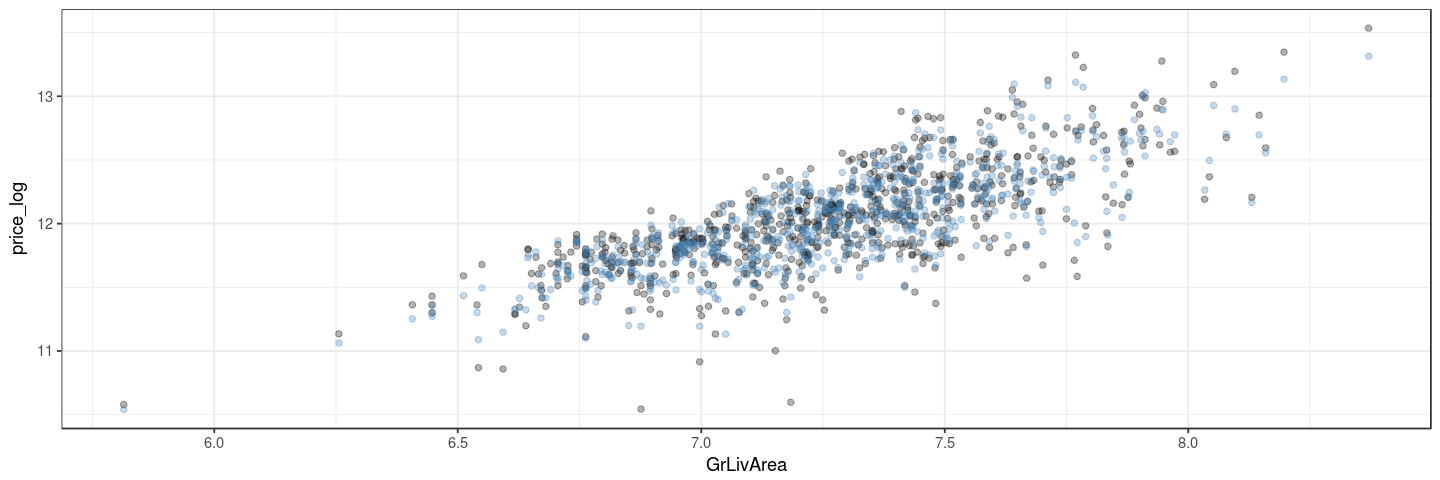

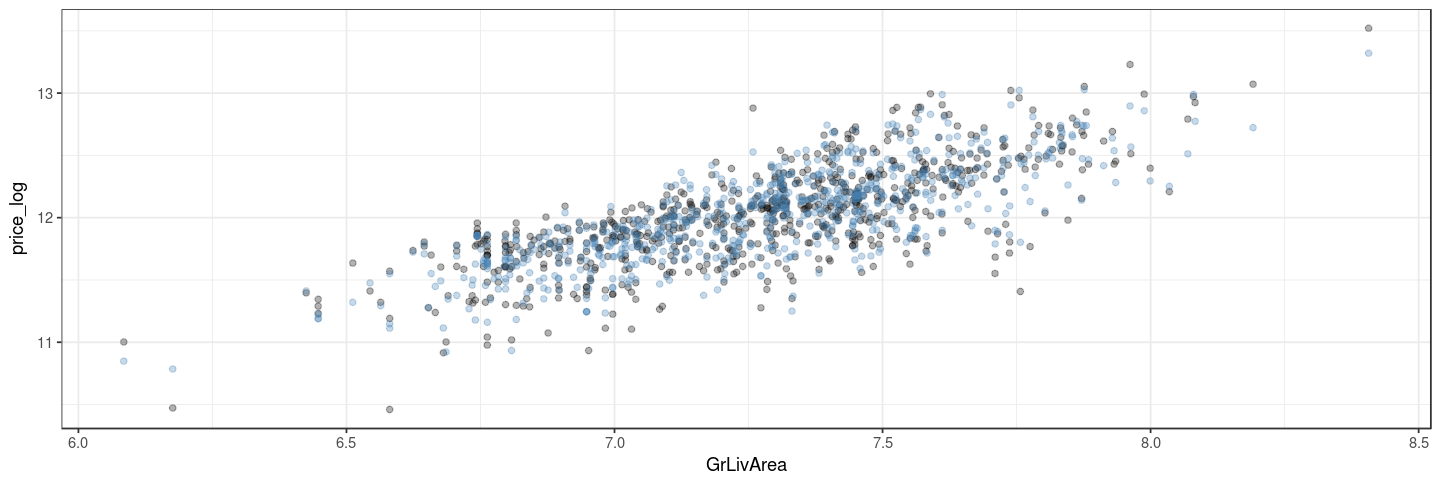

In [33]:
testset %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=price_log), alpha=0.3) +
geom_point(aes(x=GrLivArea, y=price_log_predicted), alpha=0.3, color='steelblue') +
theme_bw()

mod %>%
augment %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=price_log), alpha=0.3) +
geom_point(aes(x=GrLivArea, y=.fitted), alpha=0.3, color='steelblue') +
theme_bw()

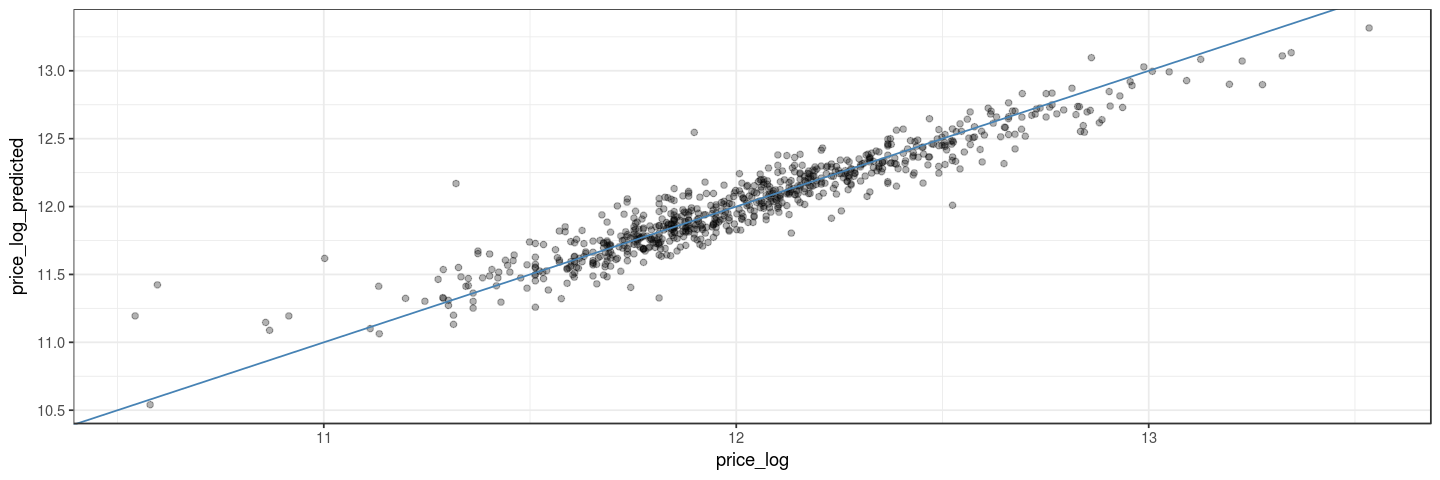

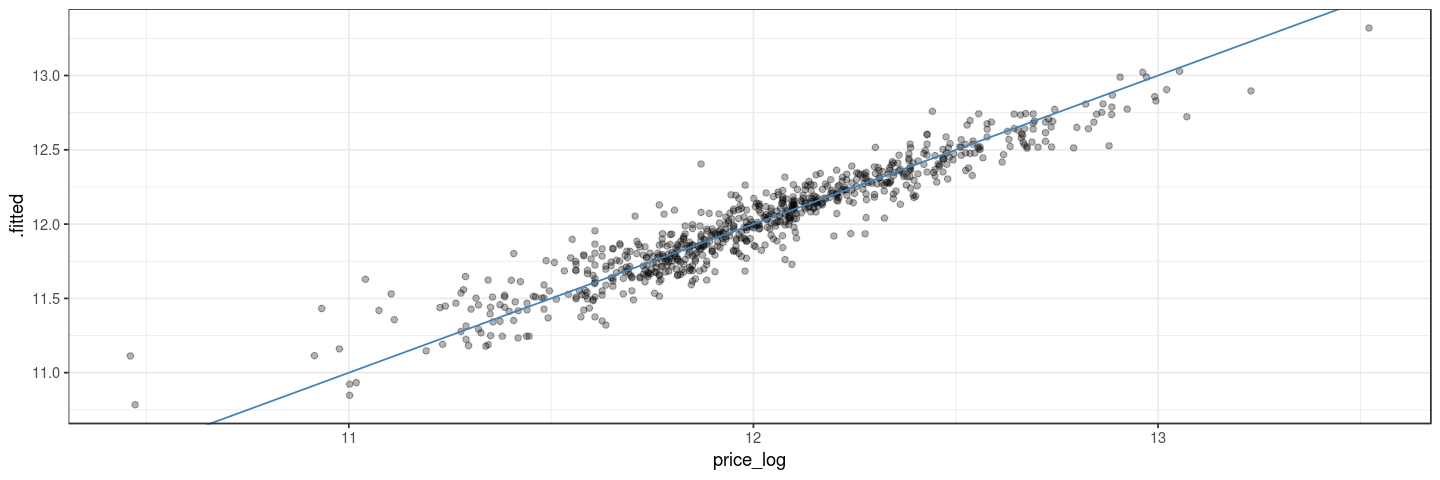

In [34]:
testset %>%
ggplot() +
geom_point(aes(x=price_log, y=price_log_predicted), alpha=0.3) +
geom_abline(intercept=0, slope=1, color='steelblue') +
theme_bw()

mod %>%
augment %>%
ggplot() +
geom_point(aes(x=price_log, y=.fitted), alpha=0.3) +
geom_abline(intercept=0, slope=1, color='steelblue') +
theme_bw()